In [5]:
from __future__ import print_function

# Standard modules
import os
import pickle
import numpy as np
import nibabel as nib

# Dipy modules
import dipy.viz.regtools as rt
import dipy.align.imwarp as imwarp
from dipy.align import VerbosityLevels
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import regtransforms

# EPI correction (new) modules
import dipy.correct.gradients as gr
from dipy.correct.splines import CubicSplineField
from dipy.correct.epicor import (SingleEPI_ECC,
                                 OffResonanceFieldEstimator)
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)
floating = np.float64

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [6]:
# Load data
data_dir = '/home/omar/data/topup_example/'

epi_fname = '/home/omar/data/SCIL/SCIL_01/SCIL_01_b0_up_strip.nii.gz'
nonepi_fname = '/home/omar/data/SCIL/SCIL_01/SCIL_01_t1_strip.nii.gz'

epi_nib = nib.load(epi_fname)
epi_affine = epi_nib.get_affine()
direction, spacings = imwarp.get_direction_and_spacings(epi_affine, 3)
epi = epi_nib.get_data().squeeze().astype(np.float64)

nonepi_nib = nib.load(nonepi_fname)
nonepi_affine = nonepi_nib.get_affine()
nonepi = nonepi_nib.get_data().squeeze().astype(np.float64)
nonepi /=nonepi.max()

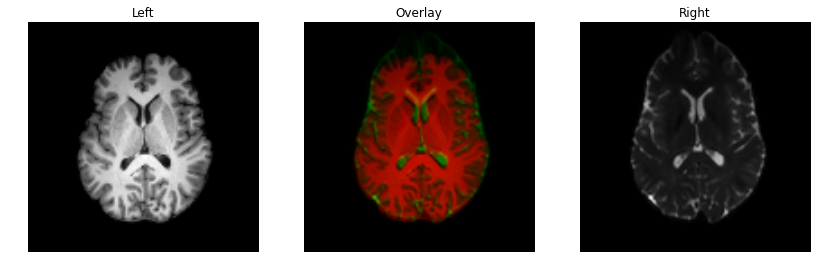

In [11]:
# Resample nonepi on top of epi
affmap = AffineMap(None, epi.shape, epi_affine, nonepi.shape, nonepi_affine)
nonepi_resampled = affmap.transform(nonepi)
rt.overlay_slices(nonepi_resampled, epi, slice_type=2);

In [7]:
radius = 4

# Preprocess intensities
epi /= epi.mean()

# Configure and run orfield estimation
epi_pedir = np.array((0,1,0), dtype=np.float64)
nonepi_pedir = np.array((0,0,0), dtype=np.float64)
distortion_model = SingleEPI_ECC(radius=radius, q_levels=256)
level_iters = [200, 200, 200, 200, 200, 200, 200, 200, 200]
lambdas = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                   0.5, 0.05, 0.05])*300
fwhm = np.array([8, 6, 4, 3, 3, 2, 1, 0, 0])
estimator = OffResonanceFieldEstimator(distortion_model, level_iters=level_iters, lambdas=lambdas, fwhm=fwhm)

orfield_coef_fname = 'orfield_coef_single_ecc_ss.p'
orfield = None
if os.path.isfile(orfield_coef_fname):
    coef = pickle.load(open(orfield_coef_fname, 'r'))
    kspacing = np.round(estimator.warp_res[-1]/spacings)
    kspacing = kspacing.astype(np.int32)
    kspacing[kspacing < 1] = 1
    orfield = CubicSplineField(epi.shape, kspacing)
    orfield.copy_coefficients(coef)
else:
    orfield = estimator.optimize_with_ss(epi, epi_affine, epi_pedir,
                                         nonepi, nonepi_affine, nonepi_pedir,
                                         spacings)
    pickle.dump(np.array(orfield.coef), open(orfield_coef_fname, 'w'))


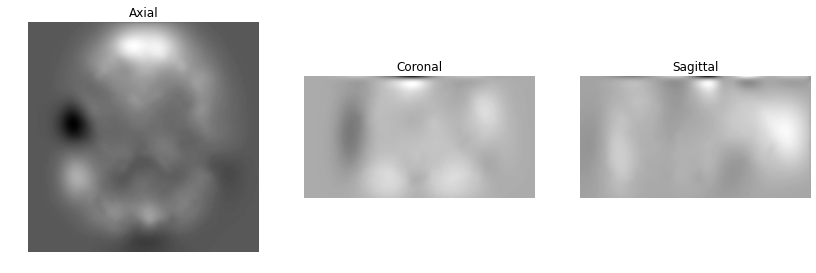

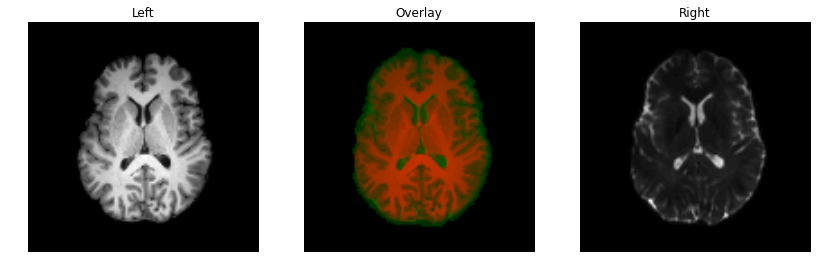

In [12]:
b  = np.array(orfield.get_volume((0, 0, 0)))
db = np.array(orfield.get_volume((0, 1, 0)))
shape = np.array(epi.shape, dtype=np.int32)
w_epi, _m = gr.warp_with_orfield(epi, b, epi_pedir, None,
                                None, None, shape)


rt.plot_slices(b);
rt.overlay_slices(nonepi_resampled, w_epi*(1+db), slice_type=2);